In [1]:
import sys
import os

import so_ml_tools as soml

import tensorflow as tf
import numpy as np
import keras as ks
import opendatasets as od

from keras import Sequential, Model
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
from keras.utils import image_dataset_from_directory

2023-09-29 12:12:51.912326: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [23]:
!nvidia-smi

/bin/bash: /home/sodeso/anaconda3/envs/ml/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Failed to initialize NVML: Driver/library version mismatch
NVML library version: 535.113


# Configure mixed-precision so we can improve the performance

In [2]:
# BASE_MODEL_NAME is used as a folder name for saved models.
IMG_SHAPE = (224, 224)

# Download the dataset from Kaggle (kaggle.json API key neccesary)

In [3]:
# Download the dogs and cats dataset
od.download_kaggle_dataset(dataset_url="https://www.kaggle.com/datasets/chetankv/dogs-cats-images/download?datasetVersionNumber=1",
                           data_dir="./data")

Skipping, found downloaded files in "./data/dogs-cats-images" (use force=True to force download)


# Inspect the contents of the downloaded dataset

In [4]:
TRAIN_DIR = "./data/dogs-cats-images/dataset/training_set"
TEST_DIR = "./data/dogs-cats-images/dataset/test_set"

In [5]:
soml.util.io.list_dir_summary(TRAIN_DIR)

There are 2 directories, and 0 in ./data/dogs-cats-images/dataset/training_set
There are 0 directories, and 4000 in ./data/dogs-cats-images/dataset/training_set/dogs
There are 0 directories, and 4000 in ./data/dogs-cats-images/dataset/training_set/cats


In [6]:
soml.util.io.list_dir_summary(TEST_DIR)

There are 2 directories, and 0 in ./data/dogs-cats-images/dataset/test_set
There are 0 directories, and 1000 in ./data/dogs-cats-images/dataset/test_set/dogs
There are 0 directories, and 1000 in ./data/dogs-cats-images/dataset/test_set/cats


# Show some random images from disk of the downloaded dataset

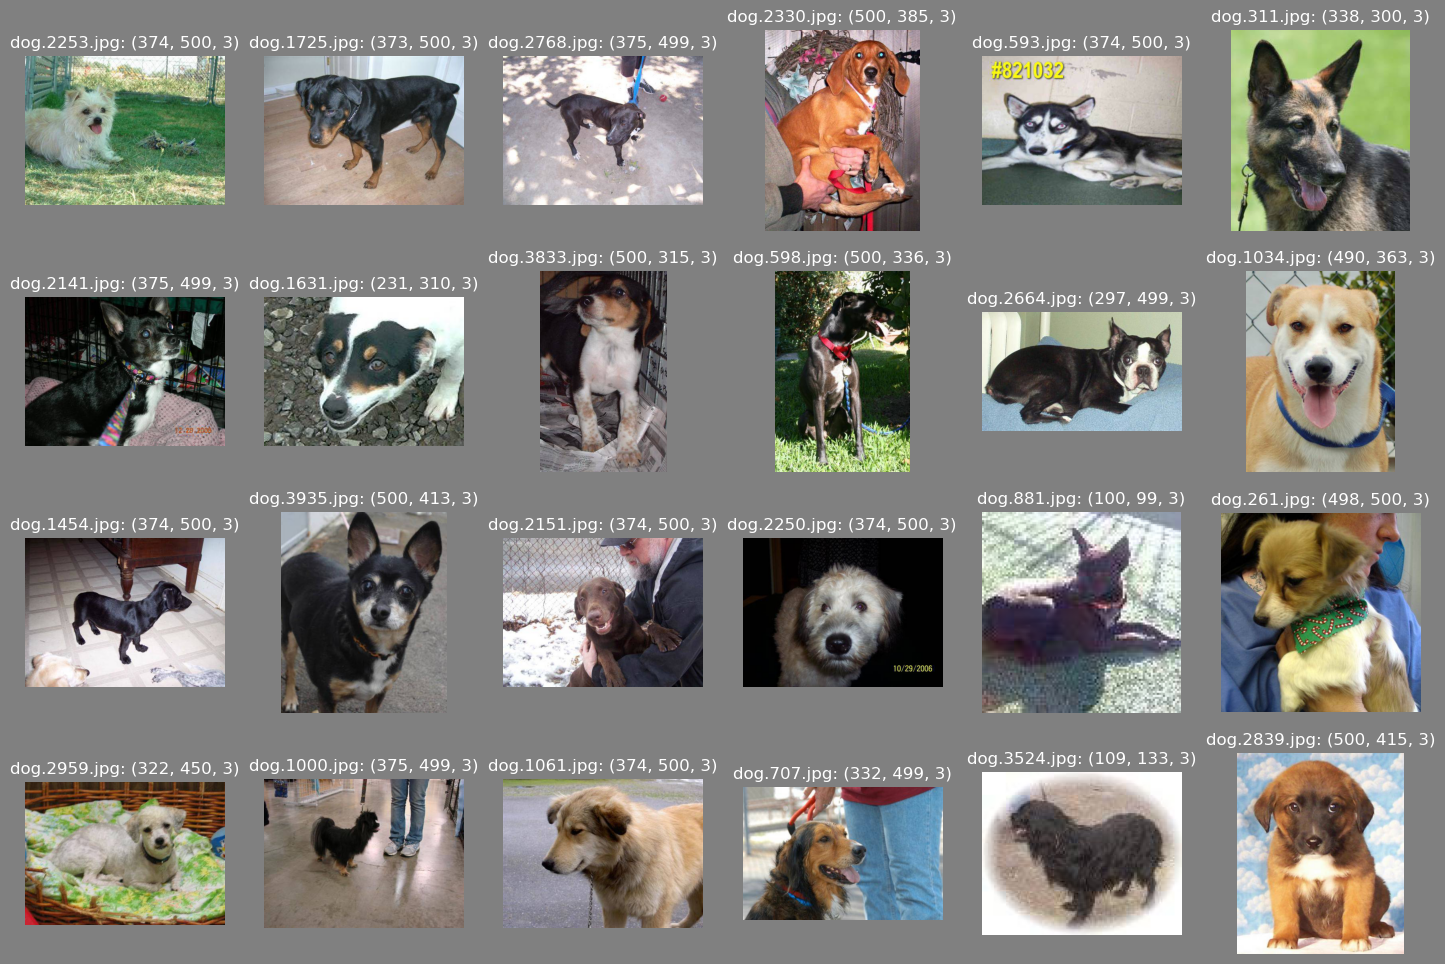

In [7]:
soml.data.image.show_random_image_from_disk(target_dir=TRAIN_DIR, target_class="dogs")

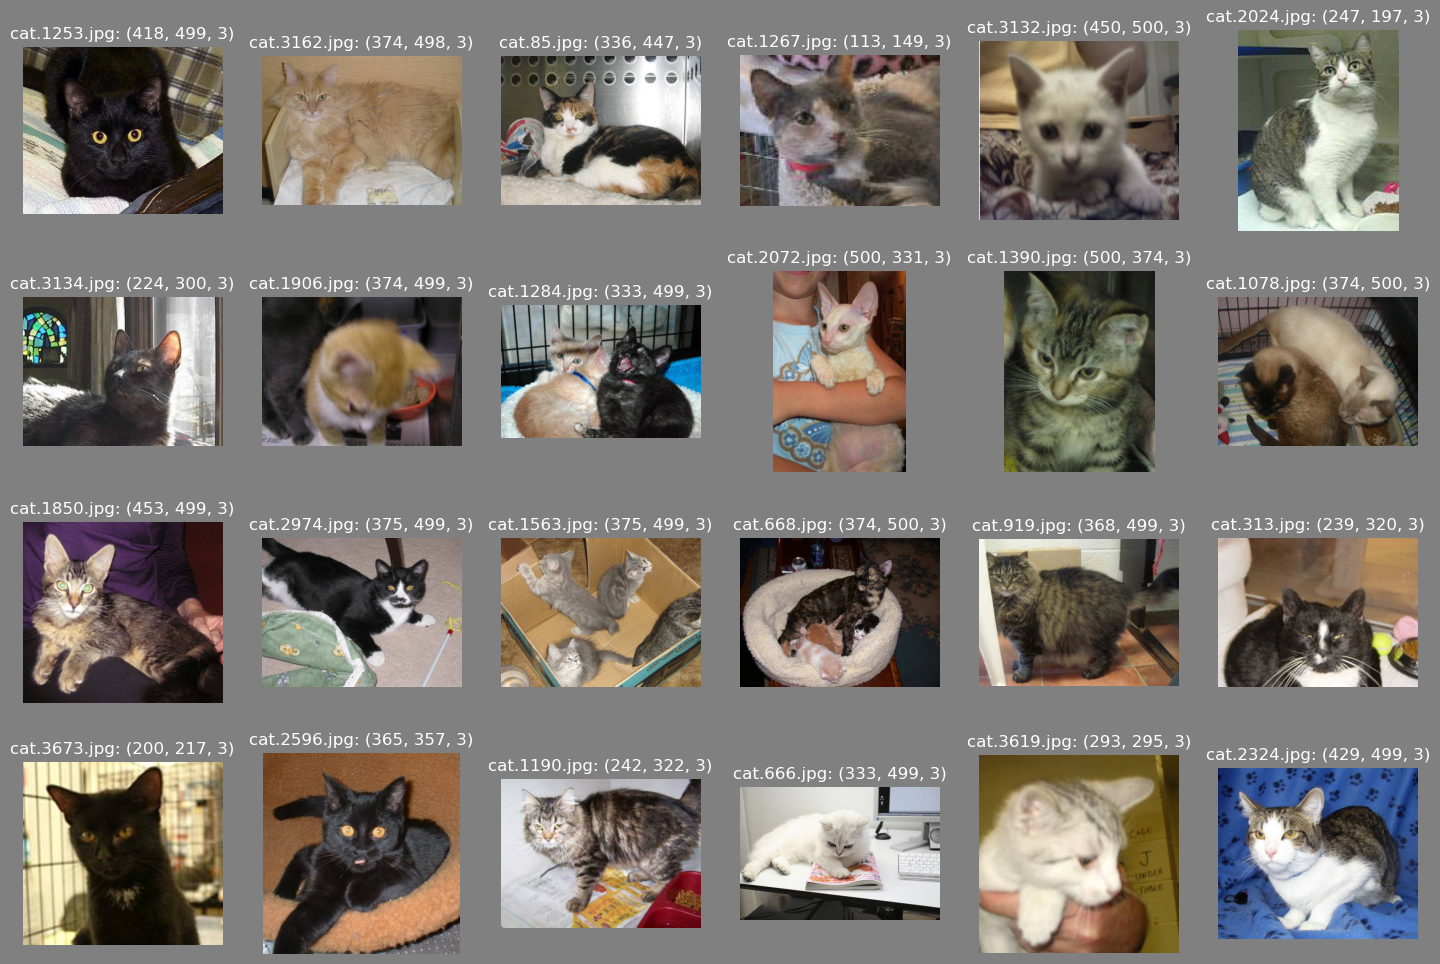

In [8]:
soml.data.image.show_random_image_from_disk(target_dir=TRAIN_DIR, target_class="cats")

# Create datasets for the train and test images

In [16]:
train_dataset = soml.data.loader.load_image_dataset_from_directory(directory=TRAIN_DIR,
                             label_mode="categorical",
                             batch_size=32,
                             image_size=IMG_SHAPE,
                             shuffle=True)

test_dataset = soml.data.loader.load_image_dataset_from_directory(directory=TEST_DIR,
                             label_mode="categorical",
                             batch_size=32,
                             image_size=IMG_SHAPE,
                             shuffle=False)

train_dataset = soml.tf.dataset.add_prefetching(dataset=soml.tf.dataset.add_shuffling(dataset=soml.tf.dataset.add_caching(dataset=soml.tf.dataset.add_rescaling_mapping(dataset=train_dataset))))
test_dataset = soml.tf.dataset.add_prefetching(dataset=soml.tf.dataset.add_shuffling(dataset=soml.tf.dataset.add_caching(dataset=soml.tf.dataset.add_rescaling_mapping(dataset=test_dataset))))

len(train_images), len(test_images)

Found 8000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.
WARN: Dataset is already shuffled.
Buffer size for shuffle has been set to 1000
WARN: Dataset is already prefetched.
Buffer size for shuffle has been set to 1000
WARN: Dataset is already prefetched.


(250, 63)

# Get class-names from the dataset

In [17]:
class_names = soml.tf.dataset.get_class_names(dataset=train_images)
class_names

['cats', 'dogs']

# Inspect some random images from the dataset to check image size, and quality

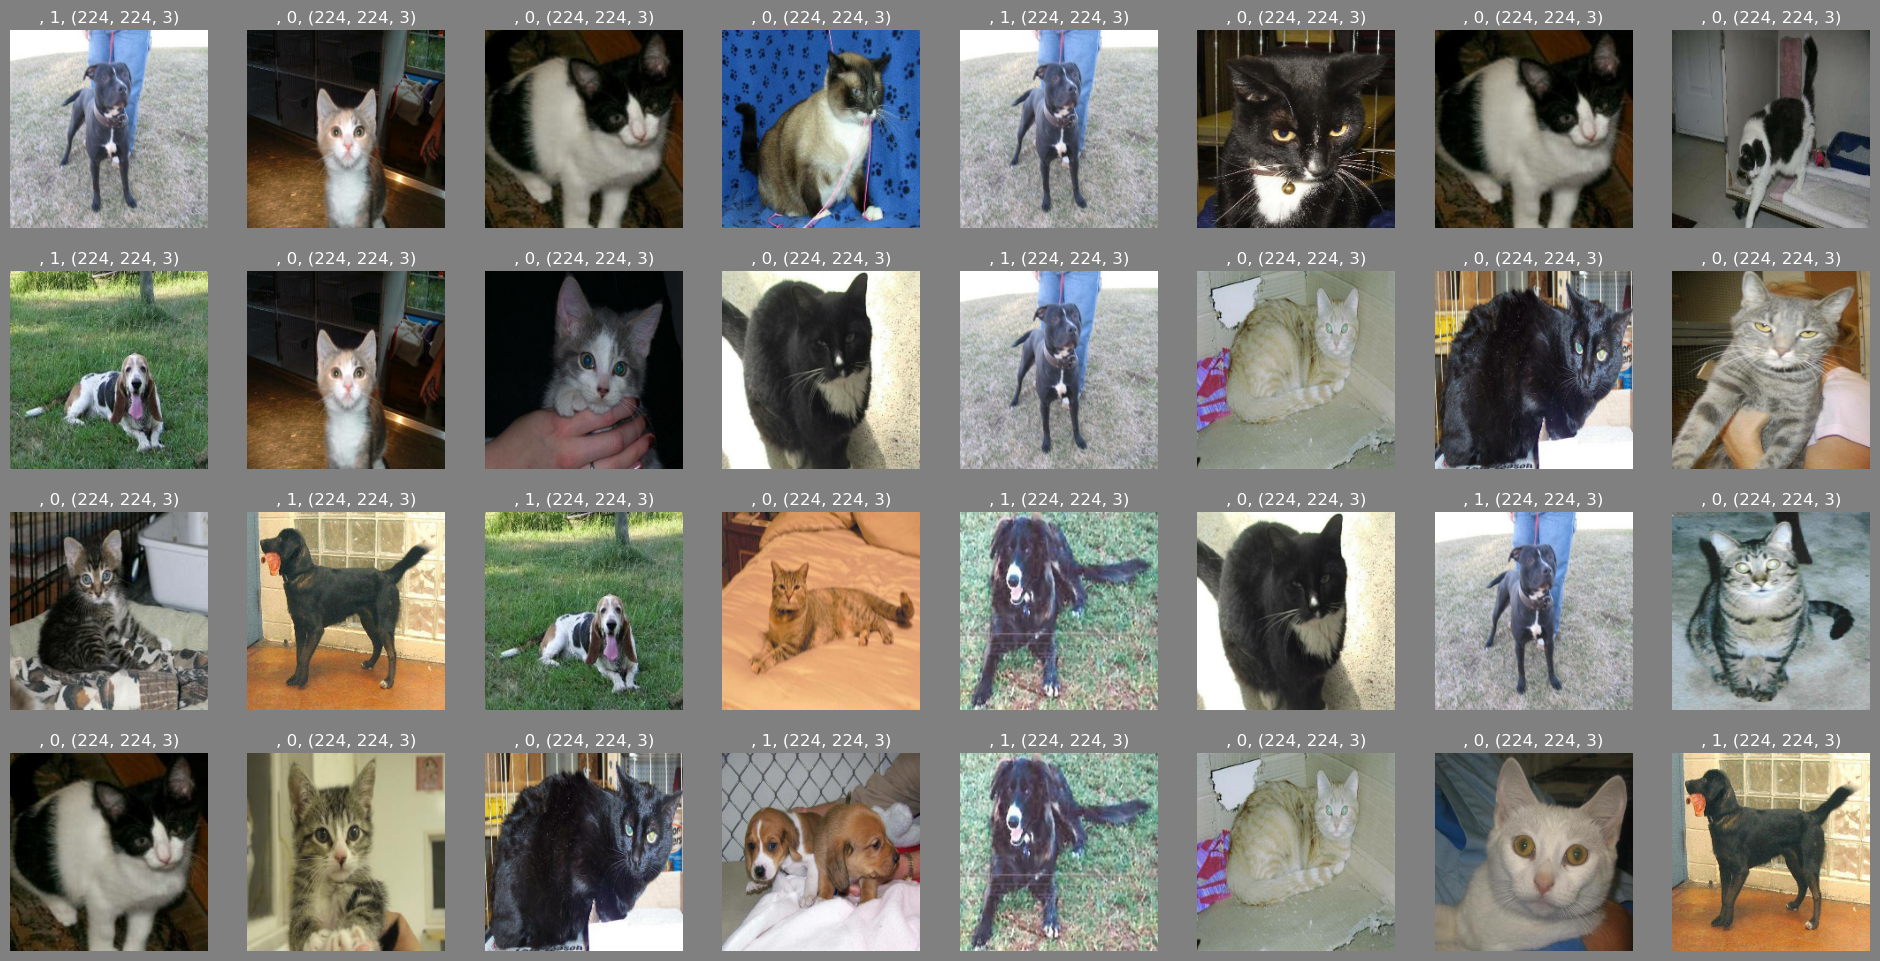

In [18]:
soml.tf.dataset.show_images_from_dataset(dataset=train_images, shape=(4, 8))

# Create the model

In [19]:
input_layer = ks.layers.Input(shape=IMG_SHAPE + (3,))

convolutional_layers = [(64, 2), (128, 2), (256, 3), (512, 3), (512, 3)]

x = input_layer
for filters, n_convs in convolutional_layers:
    for _ in np.arange(n_convs):
        x = ks.layers.Conv2D(filters=filters, kernel_size=3, activation="relu", padding='same')(x)
    x = ks.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
    
x = ks.layers.GlobalAveragePooling2D()(x)
x = ks.layers.Dense(units=64, activation="relu")(x)
x = ks.layers.BatchNormalization()(x)
output_layer = ks.layers.Dense(units=len(class_names), activation="softmax")(x)

model = Model(input_layer, output_layer)

model.compile(loss=ks.losses.CategoricalCrossentropy(),
              optimizer=ks.optimizers.Adam(),
              metrics=["accuracy"])

In [20]:
soml.tf.model.inspect.list_model(model=model)

row   | name (type)                                         | dtype   | policy  | trainable | output shape          | Total Param # | Trainable Param # | Non-trainable Param #
0     | input_2                    (InputLayer            ) | float32 | float32 | True      | [(None, 224, 224, 3)] | 0             | 0                 | 0                    
1     | conv2d_13                  (Conv2D                ) | float32 | float32 | True      | (None, 224, 224, 64)  | 1,792         | 1,792             | 0                    
2     | conv2d_14                  (Conv2D                ) | float32 | float32 | True      | (None, 224, 224, 64)  | 36,928        | 36,928            | 0                    
3     | max_pooling2d_5            (MaxPooling2D          ) | float32 | float32 | True      | (None, 112, 112, 64)  | 0             | 0                 | 0                    
4     | conv2d_15                  (Conv2D                ) | float32 | float32 | True      | (None, 112, 112, 128) | 73

# Create the neccesary callbacks to evaluate

In [21]:
early_stopping_callback = soml.tf.fit.callback.early_stopping_callback()
reduce_lr_on_plateau_callback = soml.tf.fit.callback.reduce_lr_on_plateau_callback()

# Fit the mode

In [22]:
model_history = model.fit(
    epochs=50,
    x=train_images,
    steps_per_epoch=len(train_images),
    validation_data=test_images,
    validation_steps=len(test_images),
    callbacks=[early_stopping_callback, reduce_lr_on_plateau_callback],
)

Epoch 1/50
 34/250 [===>..........................] - ETA: 5:20 - loss: 0.6986 - accuracy: 0.5303

KeyboardInterrupt: 

# Inspect the history of fitting the model

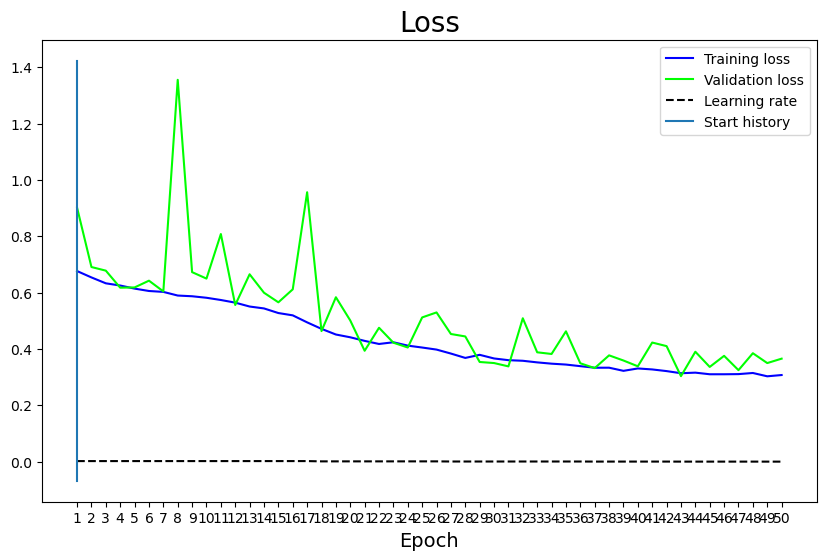

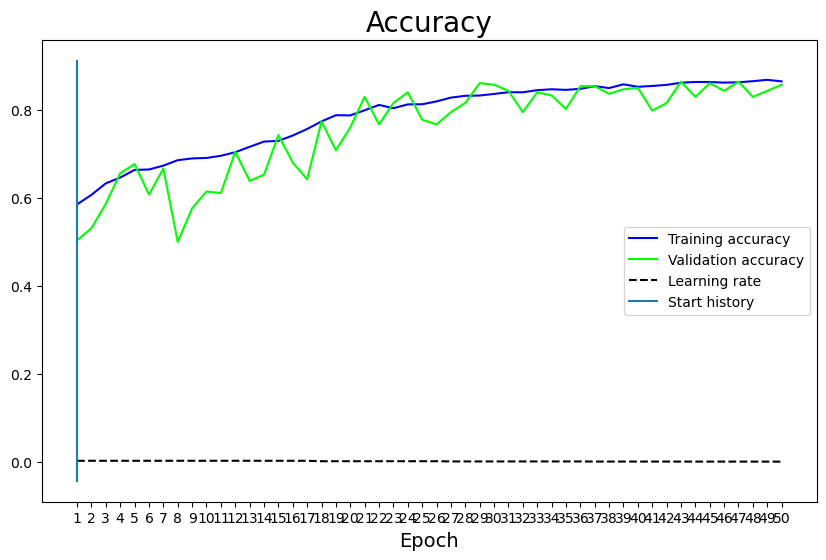

In [15]:
soml.tf.model.plot.plot_history(history=model_history)

# Evaluate the model

In [1]:
model_evaluation = model.evaluate(x=test_images)
model_evaluation

NameError: name 'model' is not defined

# Create confusion matrix on all the predictions of the test images

In [17]:
y_true, y_pred = mll.predict_classification_dataset_with_labels(model, test_images)

1/1 [==============================] - 0s 111ms/step


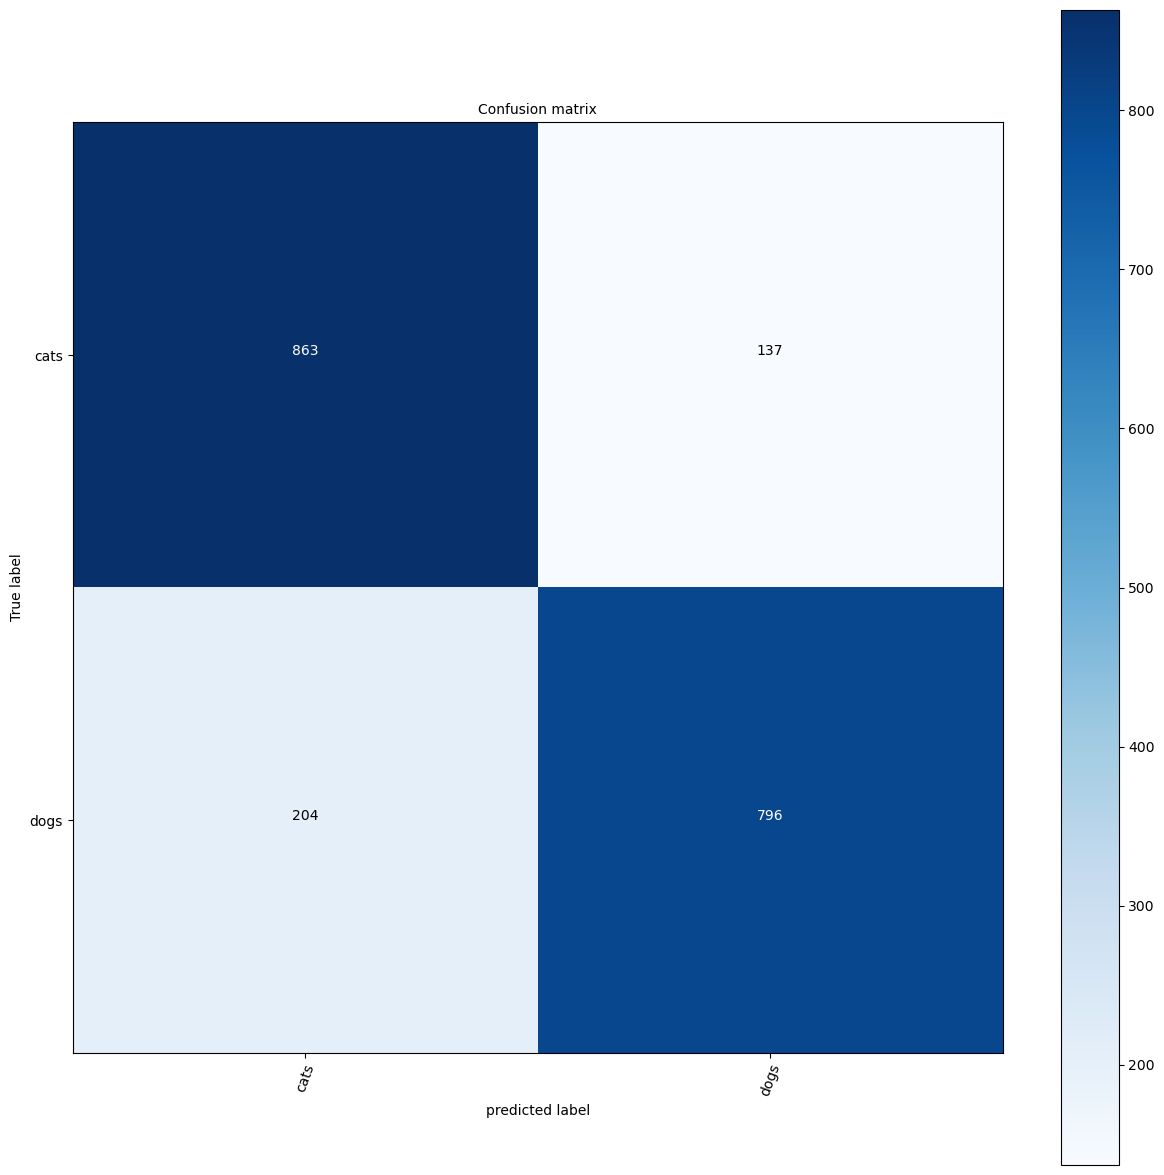

In [18]:
mlp.plot_classification_confusion_matrix(y_true=y_true, y_pred=y_pred, class_names=class_names)

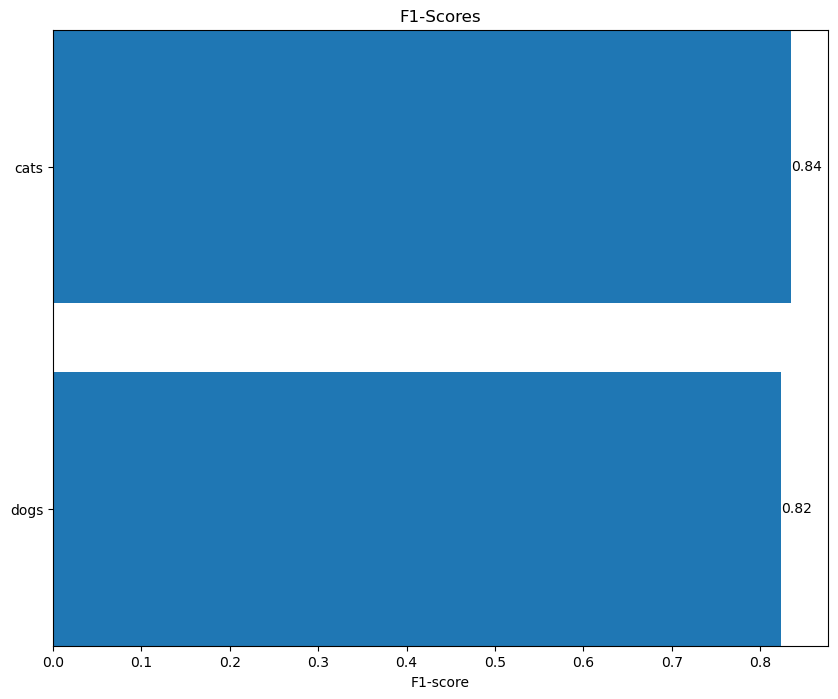

In [19]:
mlp.plot_classification_report_f1_score(y_true=y_true, y_pred=y_pred, class_names=class_names)

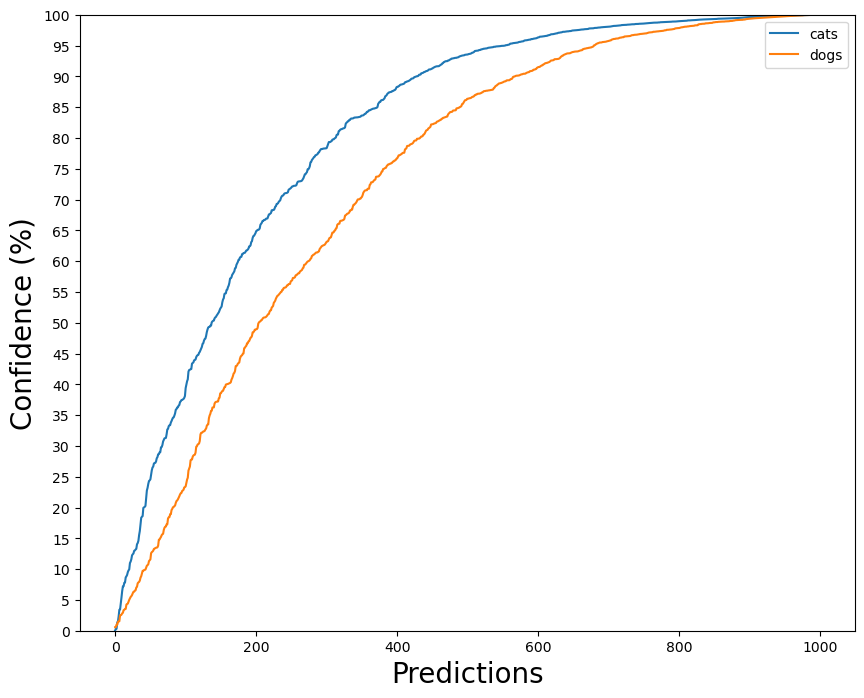

In [20]:
mlp.plot_classification_prediction_confidence(y_true=y_true, y_pred=y_pred, class_names=class_names)

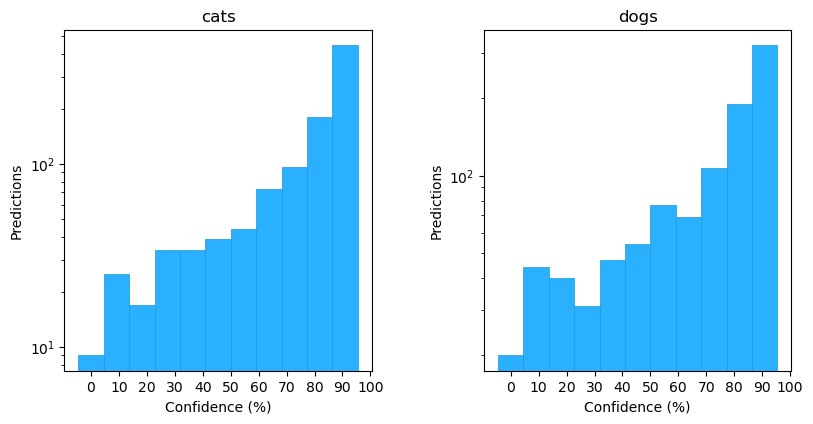

In [21]:
mlp.plot_classification_prediction_confidence_histogram(y_true=y_true, y_pred=y_pred, class_names=class_names)


# Make some predictions of our own

In [22]:
SAMPLES_DIR = "./samples"

mli.list_dir_summary(SAMPLES_DIR)

There are 0 directories, and 6 in ./samples


In [ ]:
cat = mli.load_image_as_tensor(filename=os.path.join(SAMPLES_DIR, "cat_1.jpeg"), img_shape=IMG_SHAPE, scale=False)
y = mlint.sparse_labels(model.predict(x=mld.add_batch_to_tensor(cat)))
mlv.show_single_image_from_nparray_or_tensor(image=cat, title=f"Pred: {class_names[y[0]]}")

In [ ]:
cat = mli.load_image_as_tensor(filename=os.path.join(SAMPLES_DIR, "cat_2.jpeg"), img_shape=IMG_SHAPE, scale=False)
y = mlint.sparse_labels(model.predict(x=mld.add_batch_to_tensor(cat)))
mlv.show_single_image_from_nparray_or_tensor(image=cat, title=f"Pred: {class_names[y[0]]}")

In [ ]:
cat = mli.load_image_as_tensor(filename=os.path.join(SAMPLES_DIR, "cat_3.jpg"), img_shape=IMG_SHAPE, scale=False)
y = mlint.sparse_labels(model.predict(x=mld.add_batch_to_tensor(cat)))
mlv.show_single_image_from_nparray_or_tensor(image=cat, title=f"Pred: {class_names[y[0]]}")

In [ ]:
dog = mli.load_image_as_tensor(filename=os.path.join(SAMPLES_DIR, "dog_1.jpg"), img_shape=IMG_SHAPE, scale=False)
y = mlint.sparse_labels(model.predict(x=mld.add_batch_to_tensor(dog)))
mlv.show_single_image_from_nparray_or_tensor(image=dog, title=f"Pred: {class_names[y[0]]}")

In [ ]:
dog = mli.load_image_as_tensor(filename=os.path.join(SAMPLES_DIR, "dog_2.jpg"), img_shape=IMG_SHAPE, scale=False)
y = mlint.sparse_labels(model.predict(x=mld.add_batch_to_tensor(dog)))
mlv.show_single_image_from_nparray_or_tensor(image=dog, title=f"Pred: {class_names[y[0]]}")

In [ ]:
dog = mli.load_image_as_tensor(filename=os.path.join(SAMPLES_DIR, "dog_3.jpg"), img_shape=IMG_SHAPE, scale=False)
y = mlint.sparse_labels(model.predict(x=mld.add_batch_to_tensor(dog)))
mlv.show_single_image_from_nparray_or_tensor(image=dog, title=f"Pred: {class_names[y[0]]}")

# Save the model so we can perform a training

In [30]:
mll.save_model_alt(model=model, directory="./models", name="cats_dogs_categorical", format="h5")

In [25]:
# In case we need to load the model again
model = mll.load_model_alt(directory="./models", name="cats_dogs_categorical", format="h5")

In [26]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetv2-b3 (Function  (None, None, None, 1536)  12930622 
 al)                                                             
                                                                 
 global_average_pooling_2d (  (None, 1536)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_dense_layer (Dense)  (None, 2)                 3074      
                                                             